In [6]:
import pandas as pd

In [7]:
exercises_df = pd.read_csv('https://raw.githubusercontent.com/bhavanvir/Workout-Planner/main/exrx.csv')
exercises_df.head()

,exercise,utility,mechanics,force,target_muscles,synergist_muscles,stabilizer_muscles
0,Cable Neck Extension (with belt),Basic or Auxiliary,Isolated,Pull,['Splenius'],"['Trapezius, Upper', 'Levator Scapulae', 'Erec...","['Pectoralis Major, Sternal', 'Pectoralis Majo..."
1,Cable Standing Overhead Crunch (multi-exercise...,Auxiliary,Isolated,Pull,['Rectus Abdominis'],['Obliques'],"['Iliopsoas', 'Tensor Fasciae Latae', 'Rectus ..."
2,Cable Standing Preacher Curl,Auxiliary,Isolated,Pull,['Brachialis'],"['Biceps Brachii', 'Brachioradialis']",['Wrist Flexors']
3,Dumbbell Lying One Arm Rear Lateral Raise,Auxiliary,Isolated,Pull,"['Deltoid, Posterior']","['Infraspinatus', 'Teres Minor', 'Supraspinatu...","['Flexor Carpi Radialis', 'Extensor Carpi Radi..."
4,Single Leg Squat (with leg back),Basic or Auxiliary,Compound,Push,['Gluteus Maximus'],"['Quadriceps', 'Adductor Magnus', 'Soleus']","['Erector Spinae', 'Gluteus Medius', 'Gluteus ..."


In [9]:
force_counts = exercises_df['force'].value_counts()
print(force_counts)

Pull            802
Push            654
Push & Pull       4
Pull or Push      2
Pull / Push       1
Name: force, dtype: int64


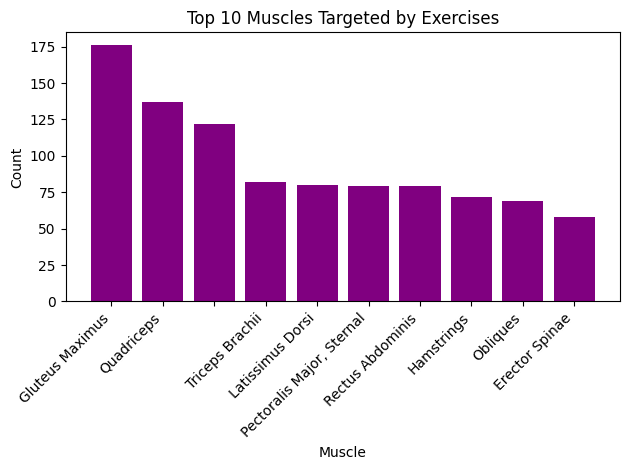

In [21]:
import matplotlib.pyplot as plt

muscles = exercises_df.explode('target_muscles')

muscle_counts = muscles['target_muscles'].value_counts()

top_n = 10
top_muscles = muscle_counts.head(top_n)

# Strip brackets from index labels
top_muscles.index = top_muscles.index.str.strip("[]'")

plt.bar(top_muscles.index, top_muscles, color='purple')
plt.title(f'Top {top_n} Muscles Targeted by Exercises')
plt.xlabel('Muscle')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
class CSP:
    def __init__(self, variables, domains, constraints, violations):
        self.variables = variables
        self.domains = domains
        self.constraints = constraints
        self.violations = violations

    def init_assignment(self):
        assignment = {var: None for var in self.variables}
        return assignment

    def is_consistent(self, assignment):
        for constraint in self.constraints:
            if not constraint(assignment):
                return False
        return True

    def is_complete(self, assignment):
        return all(assignment[var] is not None for var in self.variables)

    def select_unassigned_variable(self, assignment):
        for var in self.variables:
            if assignment[var] is None:
                return var

def recursive_backtracking(csp, assignment):
    if csp.is_complete(assignment):
        return assignment

    var = csp.select_unassigned_variable(assignment)
    for value in csp.domains:
        assignment[var] = value
        if csp.is_consistent(assignment):
            result = recursive_backtracking(csp, assignment)
            if result is not None:
                return result
        assignment[var] = None

    return None

def unary_constraint(var, violations):
    return lambda asmt: asmt[var] not in violations

def binary_constraint(var_pair, violations):
    (var1, var2) = var_pair
    return lambda asmt: (asmt[var1], asmt[var2]) not in violations

def nary_constraint(var_list, violations):
    return lambda asmt: tuple(asmt[var] for var in var_list) not in violations

In [ ]:
variables = ['WA', 'NT', 'Q', 'NSW', 'V', 'SA', 'T']
domains = ['red', 'green', 'blue']
constraints = []
violations = [('red', 'red'), ('green', 'green'), ('blue', 'blue')]

csp = CSP(variables, domains, constraints, violations)

for (var1, var2) in [('WA', 'NT'), ('WA', 'SA'),
                    ('NT', 'SA'), ('NT', 'Q'),
                    ('SA', 'Q'), ('SA', 'NSW'),
                    ('SA', 'V'),('Q', 'NSW'),
                    ('V', 'T')]:
    csp.constraints.append(binary_constraint((var1, var2), violations))

csp.constraints.append(unary_constraint('WA', ('green', 'blue')))

asmt = csp.init_assignment()
result = recursive_backtracking(csp, asmt)
print(result)

{'WA': 'red', 'NT': 'green', 'Q': 'red', 'NSW': 'green', 'V': 'red', 'SA': 'blue', 'T': 'green'}
